In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib as mpl

import raddetect as rd

In [2]:
from scipy.stats import crystalball
from scipy.stats import norm
from scipy.stats import skewnorm

In [3]:
# It works only in the MPIK network
blumchen = rd.BlumchenAnalysis(filename='Rn18062024')

Retrieving data from https://radon-srv1.mpi-hd.mpg.de/coating_db/resultfiles/Rn18062024/rn18062024.root


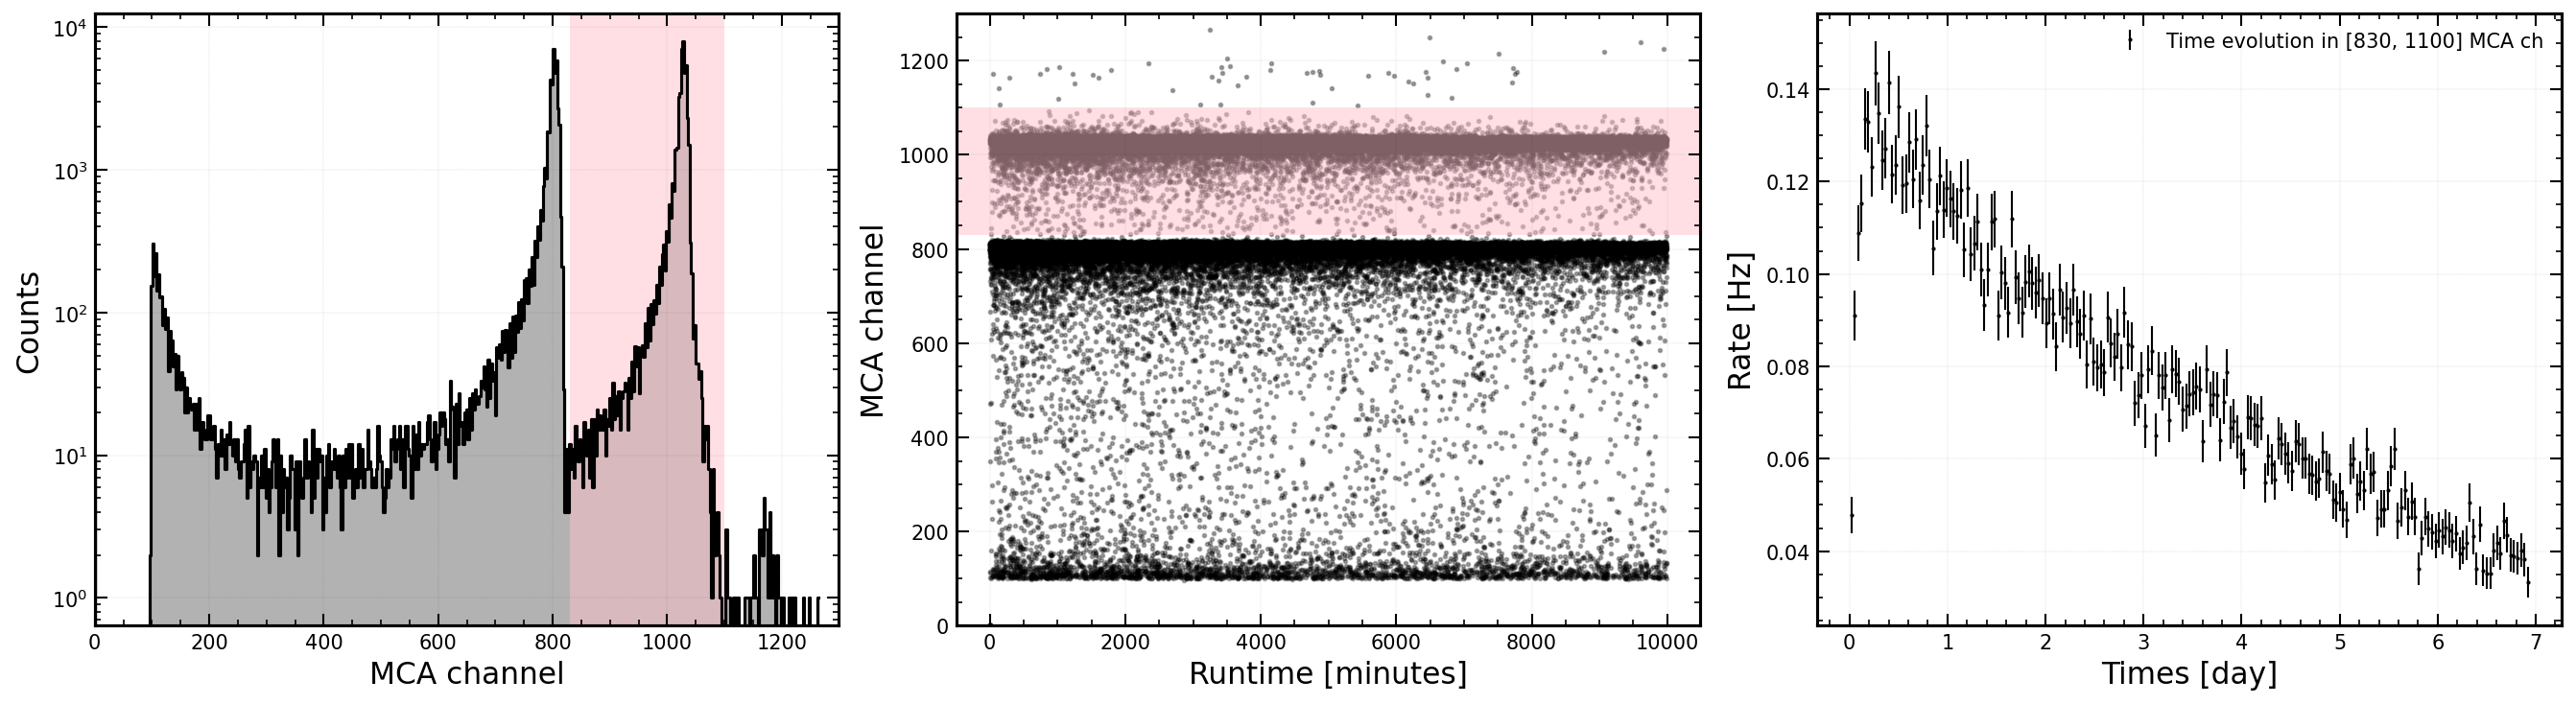

In [4]:
blumchen.get_base_plot(n_channels=500, n_timestamp=200, MCA_range=[830, 1100])

## Fir spectrum

In [ ]:
class Model:
    def __init__(self, 
                x, 
                beta1, m1, loc1, scale1, A1, 
                beta2, m2, loc2, scale2, A2, 
                # a1s, loc1s, scale1s, A1s, 
                a1s, A1s, 
                # a2s, loc2s, scale2s, A2s
                a2s, A2s
                ):
        self.x = x
        self.beta1 = beta1
        self.m1 = m1
        self.loc1 = loc1
        self.scale1 = scale1
        self.A1 = A1
        self.beta2 = beta2
        self.m2 = m2
        self.loc2 = loc2
        self.scale2 = scale2
        self.A2 = A2
        self.a1s = a1s
        self.loc1s = loc1
        self.scale1s = scale1
        self.A1s = A1s
        self.a2s = a2s
        self.loc2s = loc2
        self.scale2s = scale2
        self.A2s = A2s
        self.compute_terms()

    def compute_terms(self):
        self.crystalball_1 = self.A1 * crystalball.pdf(self.x, self.beta1, self.m1, loc=self.loc1, scale=self.scale1)
        self.skewnorm_1 = self.A1s * skewnorm.pdf(self.x, self.a1s, loc=self.loc1s, scale=self.scale1s)
        self.crystalball_2 = self.A2 * crystalball.pdf(self.x, self.beta2, self.m2, loc=self.loc2, scale=self.scale2) 
        self.skewnorm_2 = self.A2s * skewnorm.pdf(self.x, self.a2s, loc=self.loc2s, scale=self.scale2s)

    def sum_terms(self):
        return self.crystalball_1 + self.skewnorm_1 + self.crystalball_2 + self.skewnorm_2

    @staticmethod
    def total_model(x, 
                    beta1, m1, loc1, scale1, A1, 
                    beta2, m2, loc2, scale2, A2, 
                    # a1s, loc1s, scale1s, A1s, 
                    a1s, A1s, 
                    # a2s, loc2s, scale2s, A2s
                    a2s, A2s):
        model_instance = Model(x, 
                            beta1, m1, loc1, scale1, A1, 
                            beta2, m2, loc2, scale2, A2, 
                            # a1s, loc1s, scale1s, A1s, 
                            a1s, A1s, 
                            # a2s, loc2s, scale2s, A2s
                            a2s, A2s)
        return model_instance.sum_terms()

In [ ]:
init = {
    'beta1': 0.552, 'm1': 2.29, 'loc1': 807.11, 'scale1': 3.65, 'A1': 72.4e3,
    'beta2': 1.048, 'm2': 1.986, 'loc2': 1.029435e3, 'scale2': 4.897, 'A2': 98.3e3,
    # 'a1s': -2.95, 'loc1s': 805.04, 'scale1s': 5.46, 'A1s': 21.9e3,
    'a1s': -2.95, 'A1s': 21.9e3,
    # 'a2s': 1.568, 'loc2s': 1029.57+50, 'scale2s': 5.057, 'A2s': 101.2e3/2,
    'a2s': 100, 'A2s': 101.2e3/2,
}

fixed = {
    # 'beta1': True, 'm1': True, 'loc1': True, 'scale1': True, 'A1': True,
    # 'beta2': True, 'm2': True, 'loc2': True, 'scale2': True, 'A2': True,
    # 'a1s': True, 'loc1s': True, 'scale1s': True, 'A1s': True,
    # 'a1s': True, 'A1s': True,
    # 'a2s': True,
}

limits = {
    # 'a2s': [0, np.inf]    
}

_MCA_range = [600, 1150]
_MCA_counts_limit = 4
m = blumchen.get_mca_spectrum_fitting_object(model=Model, init=init, limits=limits, fixed=fixed, MCA_range=_MCA_range, MCA_counts_limit=_MCA_counts_limit)
m.migrad()
m.minos()
m.hesse()

In [ ]:
data, channels = blumchen.get_mca_histogram(MCA_range=[0, 1300])
_data, _channels = blumchen.get_mca_histogram(MCA_range=_MCA_range)
mask = (_data > _MCA_counts_limit)
_data = _data[mask]
_channels = _channels[mask]
_model = Model(_channels, *np.array(m.values))

x = np.arange(0, 1300, 0.1)
model = Model(x, *np.array(m.values))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), dpi=200, sharex=True, gridspec_kw={'height_ratios':[2,1], 'hspace': 0.05})

ax1.errorbar(channels, data, yerr=np.sqrt(data), lw=0, marker='o', color='black', ms=3, elinewidth=1, alpha=0.25)
ax1.errorbar(_channels, _data, yerr=np.sqrt(_data), lw=0, marker='o', color='black', ms=3, elinewidth=1, alpha=1)

l = ax1.plot(x, model.sum_terms(), ls='-', color='darkred', zorder=5)
ax1.plot(x, model.crystalball_1, ls='--', lw=1.5, color='red', alpha=0.5, zorder=3)
ax1.plot(x, model.skewnorm_1, ls='-.', lw=1.5, color='red', alpha=0.5, zorder=3)
ax1.plot(x, model.crystalball_2, ls='--', lw=1.5, color='orange', alpha=0.5, zorder=3)
ax1.plot(x, model.skewnorm_2, ls='-.', lw=1.5, color='orange', alpha=0.5, zorder=3)

ax2.plot(_channels, (_data - _model.sum_terms()) / np.sqrt(_data), lw=0, marker='.', color=l[0].get_color())

ax2.axhspan(-2, 2, color='yellow', lw=0, alpha=0.25)
ax2.axhspan(-1, 1, color='green', lw=0, alpha=0.35)

ax1.set_yscale('log')
ax1.set_ylim(1e0, 1e4)
ax1.set_xlim(400, 1300)

ax1.grid()

# ax2.set_ylim(-5, 50)
ax2.grid()

ax2.set_xlabel('MCA channel')
ax1.set_ylabel('Counts')
ax2.set_ylabel('Residual [$\sigma$]')
        
plt.tight_layout()
plt.show()

## Fit time evolution

In [5]:
class Model:
    def __init__(self, 
                x, 
                A, tau, t0
                ):
        self.x = x
        self.A = A
        self.tau = tau
        self.t0 = t0
        self.compute_terms()

    def compute_terms(self):
        # self.exp = self.A * (1 - np.exp(- (self.x - self.t0) / self.tau ) ) # For accumaltion mode
        self.exp = self.A * (np.exp(- (self.x - self.t0) / self.tau ) ) # For expansion mode

    def sum_terms(self):
        return self.exp

    @staticmethod
    def total_model(x, A, tau, t0):
        model_instance = Model(x, A, tau, t0)
        return model_instance.sum_terms()

In [6]:
init = {
    'A': 10, 'tau': 3.8 * 24 * 60 * 60 / np.log(2), 't0': 4 * 60 * 60,
}
fixed = {
    'tau': True,
    't0': True,
}

_n_timestamp = 150
m = blumchen.get_time_evolution_fitting_object(model=Model, init=init, fixed=fixed, n_timestamp=_n_timestamp)
m.migrad()
m.minos()
m.hesse()

Prefit with scipy for deriving inital values
| Parameters | Value       | Error       |
------------------------------------------
| A          |       0.130 |       0.023 |
| tau        |  473665.636 |    6652.216 |
| t0         |   14400.000 |   83037.899 |
------------------------------------------


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 163.5 (χ²/ndof = 1.1)      │              Nfcn = 18               │
│ EDM = 1.81e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ 130.4e-3  │  0.6e-3   │  -0.6e-3   │   0.6e-3   │         │         │       │
│ 1 │ tau  │   474e3   │    5e3    │            │            │         │         │  yes  │
│ 2 │ t0   │  14.40e3  │  0.14e3   │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │           A           │
├──────────┼───────────┬───────────┤
│  Error   │  -0.6e-3  │  0.6e-3   │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌─────┬────────────────────────────┐
│     │        A      tau       t0 │
├─────┼────────────────────────────┤
│   A │ 3.88e-07        0        0 │
│ tau │        0        0        0 │
│  t0 │        0        0        0 │
└─────┴────────────────────────────┘

/tmp/ipykernel_15165/1223176613.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


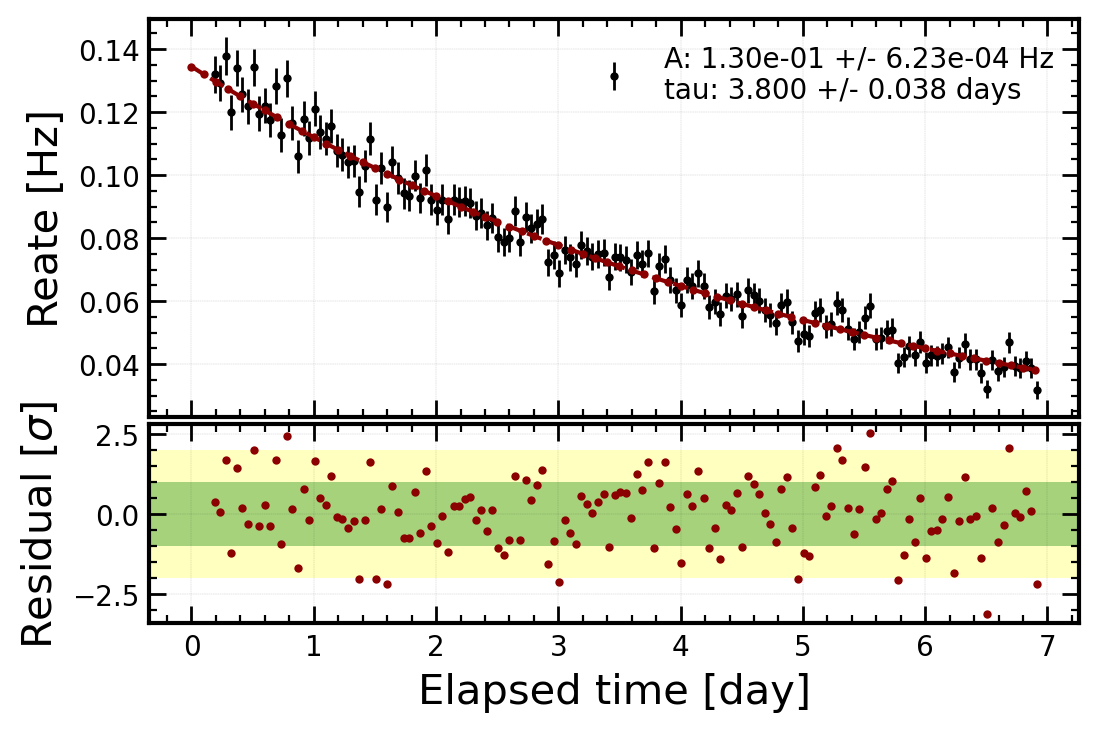

In [7]:
from_tau_to_halflife = 24 * 60 * 60 / np.log(2)
label = f'{m.parameters[0]}: {m.values[m.parameters[0]]:.2e} +/- {m.errors[m.parameters[0]]:.2e} Hz\n'
label += f'{m.parameters[1]}: {m.values[m.parameters[1]] / from_tau_to_halflife:.3f} +/- {m.errors[m.parameters[1]] / from_tau_to_halflife:.3f} days'

times, rate, rate_err = blumchen.get_time_evolution(n_timestamp=_n_timestamp)
_model = Model(times, *np.array(m.values))

x = np.arange(0, max(times / 60 / 60 / 24), 0.1)
model = Model(x * 60 * 60 * 24, *np.array(m.values))

fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200, sharex=True, gridspec_kw={'height_ratios':[2,1], 'hspace': 0.025})

ax1.errorbar(times / 60 / 60 / 24, rate, yerr=rate_err, lw=0, marker='o', color='black', ms=3, elinewidth=1, label=label)

l = ax1.plot(x, model.sum_terms(), marker='o', ls='--', ms=3, color='darkred', zorder=5)

ax2.plot(times / 60 / 60 / 24, (rate - _model.sum_terms()) / rate_err, lw=0, marker='.', color=l[0].get_color())

ax2.axhspan(-2, 2, color='yellow', lw=0, alpha=0.25)
ax2.axhspan(-1, 1, color='green', lw=0, alpha=0.35)

ax1.grid()
ax2.grid()

ax2.set_xlabel('Elapsed time [day]')
ax1.set_ylabel('Reate [Hz]')
ax2.set_ylabel('Residual [$\sigma$]')

ax1.legend()

plt.tight_layout()
plt.show()

In [8]:
eff = 34/100 # efficiency blumche
eff_err = 4/100 # rough estimate

A_true = m.values[m.parameters[0]]/eff
A_true_err = np.sqrt( (m.errors[m.parameters[0]]/m.values[m.parameters[0]])**2 + eff_err**2 )

print(f'Corrected activity: {A_true:.2f} +/- {A_true_err:.2f} Bq')

Corrected activity: 0.38 +/- 0.04 Bq
